In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from scipy.cluster import hierarchy

In [2]:
election_path = "2020/ca/city/san_francisco"
election_kind = "general"

election_basename = election_path.replace("/", "__") + f"__{election_kind}"

def read_data(kind):
    path_marks = f"data_processed/{election_path}/{election_basename}/{kind}.pq"
    return pd.read_parquet(path_marks)

df_marks = read_data("marks")
df_contests = read_data("contests")[['Description', 'VoteFor', 'NumOfRanks']].rename(columns={'Description': 'Contest'})
df_candidates = read_data("candidates")[['Description']].rename(columns={'Description': 'Candidate'})

In [3]:
mm_nonrcv = df_contests[(df_contests['VoteFor'] > 1) & (df_contests['NumOfRanks'] == 0)].index
df = df_marks.loc[mm_nonrcv]
df = df[df["is_vote"] & ~df["is_ambiguous"]]

In [4]:
%%time

df_corrs = {}
df_fracs = {}
for contest_id, df_corr in df.groupby(['contest_id']):
    df_corr = df_corr.join(df_candidates)
    df_corr['mark'] = 1
    df_corr = df_corr.pivot_table(
        values='mark', 
        index=['contest_id', 'ballot_contest_id'], 
        columns='Candidate', 
        fill_value=0,
    )
    contest = df_contests.loc[contest_id, 'Contest']
    df_corrs[contest] = df_corr.corr()
    df_fracs[contest] = df_corr.T.dot(df_corr) / df_corr.sum()

CPU times: user 1.62 s, sys: 455 ms, total: 2.07 s
Wall time: 2.14 s


In [5]:
col_wrap = 2
ncontests = len(df_corrs)

ncol = ncontests if ncontests < col_wrap else col_wrap
nrow = int(np.ceil(ncontests / col_wrap))

def cluster_order(d):
    pdist = hierarchy.distance.pdist(d.values)
    linkage = hierarchy.linkage(pdist, method='complete')
    idx = hierarchy.fcluster(linkage, 0.5 * pdist.max(), 'distance')
    idx = np.argsort(idx)
    return d.iloc[idx, idx]

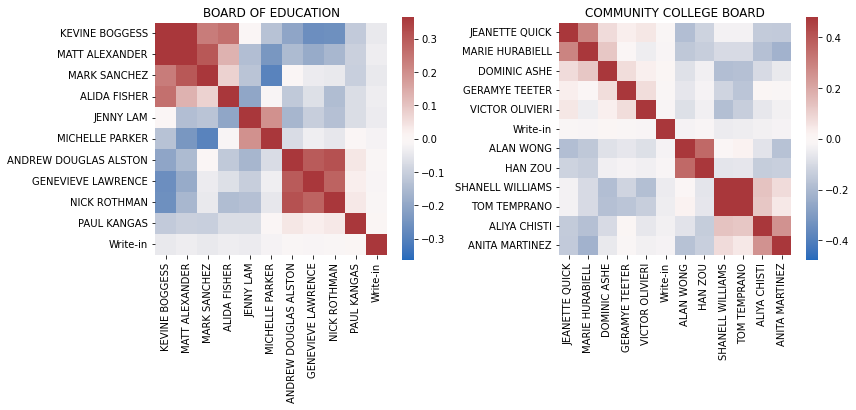

In [6]:
_, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*6, nrow*6))

for (contest, df_corr), ax in zip(df_corrs.items(), axes.flatten()):
    df_corr = cluster_order(df_corr)
    size = df_corr.shape[0]
    mask = np.triu(np.repeat(True, size))
    limit = np.abs(df_corr.values[~mask]).max()
    sns.heatmap(df_corr, square=True, 
                cmap="vlag", vmin=-limit, vmax=limit, 
                ax=ax, cbar_kws={"shrink": 0.8})

    ax.set_title(contest)
    ax.set_xlabel('')
    ax.set_ylabel('')
    
plt.tight_layout()

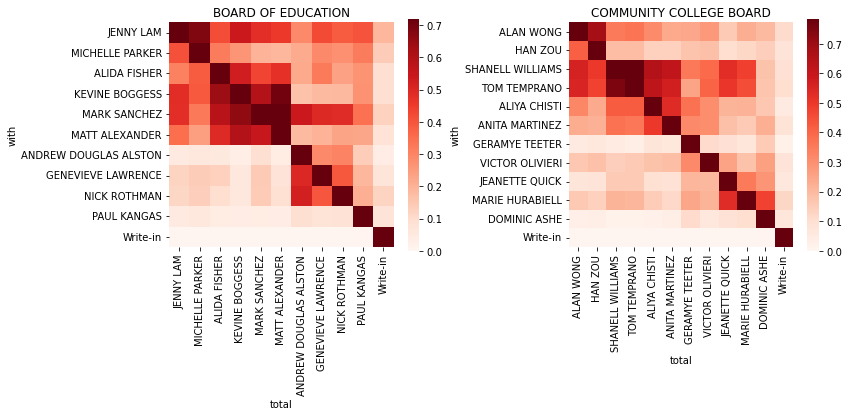

In [7]:
_, axes = plt.subplots(nrows=nrow, ncols=ncol, figsize=(ncol*6, nrow*6))

for (contest, df_frac), ax in zip(df_fracs.items(), axes.flatten()):
    df_frac = cluster_order(df_frac)
    size = df_frac.shape[0]
    mask = np.eye(size, dtype=bool)
    limit = np.abs(df_frac.values[~mask]).max()
    sns.heatmap(df_frac, square=True, 
                cmap="Reds", vmin=0, vmax=limit, 
                ax=ax, cbar_kws={"shrink": 0.8})

    ax.set_title(contest)
    ax.set_xlabel('total')
    ax.set_ylabel('with')
    
plt.tight_layout()

In [8]:
df_sizes = df.groupby(["contest_id", "candidate_id"], observed=True).size().to_frame('votes')
df_sizes = df_sizes.sort_values('votes', ascending=False).sort_index(level='contest_id', sort_remaining=False)
df_sizes = df_sizes.join(df_contests['Contest']).join(df_candidates)
df_sizes

votes                  Contest  \
contest_id candidate_id                                    
8          10            195047       BOARD OF EDUCATION   
           12            194581       BOARD OF EDUCATION   
           11            175095       BOARD OF EDUCATION   
           13            149048       BOARD OF EDUCATION   
           7             143515       BOARD OF EDUCATION   
           14            117263       BOARD OF EDUCATION   
           15             56887       BOARD OF EDUCATION   
           9              56755       BOARD OF EDUCATION   
           8              33052       BOARD OF EDUCATION   
           16             22662       BOARD OF EDUCATION   
           128             1819       BOARD OF EDUCATION   
9          51            195126  COMMUNITY COLLEGE BOARD   
           52            186364  COMMUNITY COLLEGE BOARD   
           44            126751  COMMUNITY COLLEGE BOARD   
           43            123249  COMMUNITY COLLEGE BOARD   
           45            117515  COMMUNITY COLLEGE BOARD   
           50             86627  COMMUNITY COLLEGE BOARD   
           48             74858  COMMUNITY COLLEGE BOARD   
           53             72705  COMMUNITY COLLEGE BOARD   
           49             57859  COMMUNITY COLLEGE BOARD   
           47             25538  COMMUNITY COLLEGE BOARD   
           46             18530  COMMUNITY COLLEGE BOARD   
           123             1639  COMMUNITY COLLEGE BOARD   

                                     Candidate  
contest_id candidate_id                         
8          10                        JENNY LAM  
           12                     MARK SANCHEZ  
           11                   KEVINE BOGGESS  
           13                   MATT ALEXANDER  
           7                      ALIDA FISHER  
           14                  MICHELLE PARKER  
           15                     NICK ROTHMAN  
           9                GENEVIEVE LAWRENCE  
           8             ANDREW DOUGLAS ALSTON  
           16                      PAUL KANGAS  
           128                        Write-in  
9          51                 SHANELL WILLIAMS  
           52                     TOM TEMPRANO  
           44                     ALIYA CHISTI  
           43                        ALAN WONG  
           45                   ANITA MARTINEZ  
           50                  MARIE HURABIELL  
           48                          HAN ZOU  
           53                  VICTOR OLIVIERI  
           49                   JEANETTE QUICK  
           47                   GERAMYE TEETER  
           46                     DOMINIC ASHE  
           123                        Write-in

In [9]:
df_nranks = df.groupby(["contest_id", "ballot_contest_id"], observed=True).size().to_frame("nranks")
df_nranks = df_nranks.groupby(["contest_id", "nranks"], observed=True).size().to_frame("counts")
df_nranks = df_nranks.join(df_contests["Contest"])
df_nranks

counts                  Contest
contest_id nranks                                 
8          1        67051       BOARD OF EDUCATION
           2        30433       BOARD OF EDUCATION
           3        32237       BOARD OF EDUCATION
           4       230274       BOARD OF EDUCATION
9          1        67592  COMMUNITY COLLEGE BOARD
           2        30262  COMMUNITY COLLEGE BOARD
           3        31275  COMMUNITY COLLEGE BOARD
           4       216205  COMMUNITY COLLEGE BOARD

In [10]:
def get_top(contest_id, d):
    num = df_contests.loc[contest_id]['VoteFor']
    return d.head(num)

df_winners = df.groupby(["contest_id", "candidate_id"], observed=True).size().to_frame("votes")
df_winners = df_winners.sort_values("votes", ascending=False)
df_winners = df_winners.groupby('contest_id').apply(lambda x: get_top(x.name, x))
df_winners = df_winners.join(df_contests["Contest"]).join(df_candidates)
df_winners

df['is_winner'] = df.index.isin(df_winners.index.get_level_values('candidate_id'), level='candidate_id')

In [11]:
df_stats = df.groupby(['contest_id', 'ballot_contest_id'])['is_winner'].agg(num_marks='count', num_winners='sum')
df_stats = df_stats.join(df_contests)

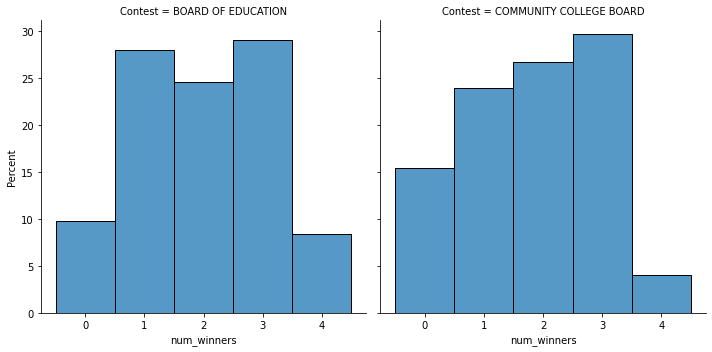

In [12]:
g = sns.FacetGrid(df_stats, col="Contest", height=5);
g.map_dataframe(sns.histplot, x="num_winners", discrete=True, stat="percent");

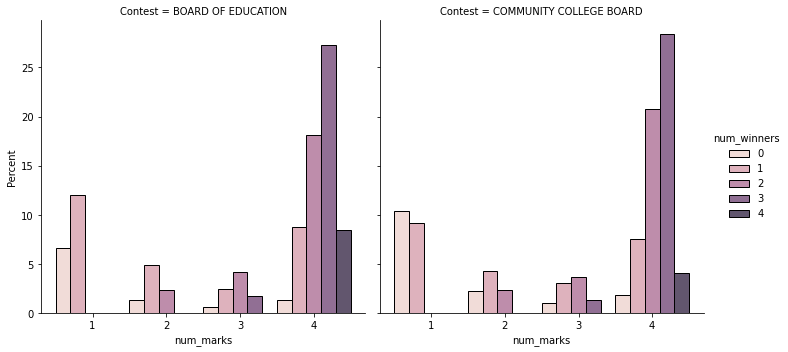

In [13]:
g = sns.FacetGrid(df_stats, col="Contest", height=5);
g._extract_legend_handles = True
g.map_dataframe(sns.histplot, x="num_marks", hue="num_winners", 
                discrete=True, multiple="dodge", stat="percent")
g.add_legend(title="num_winners");
plt.xticks([1,2,3,4]);